In [1]:
import os
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature

from joblib import Parallel, delayed
from tqdm import tqdm


### Resame the data
Get the average for each week of every year. 

The resample method groups data by a certain time interval ('W' for weekly in this case) and applies a function to each group. 

In [32]:
# uncomment last line to run
def run_resample_data():

    # Load the data (ds_all)
    ds_all_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/test2'
    ds_all = xr.open_dataset(os.path.join(ds_all_fp, 'ds_all.nc'))

    # Resample the data
    def weekly_average(ds):
        ds['time'] = pd.to_datetime(ds['time'], origin='unix', unit='D')
        
        # Resample to weekly data and compute the mean
        weekly_ds = ds.resample(time='W').mean()

        return weekly_ds

    weekly_ds_all = weekly_average(ds_all)

    # write weekly_ds_all to a netcdf file
    output_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
    if not os.path.exists(output_fp):
        os.makedirs(output_fp)

    weekly_ds_all.to_netcdf(os.path.join(output_fp, 'weekly_ds_all.nc'))

# run_resample_data()

### Load resampled weekly data

In [12]:
# Load the weekly dataset
ds_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
weekly_ds_all = xr.open_dataset(os.path.join(ds_fp, 'weekly_ds_all.nc'))

### Compute the trendlines

In [33]:
def run_compute_trendlines():

    def compute_pixel_trend(pixel_data):
        # Remove NaN values
        valid_mask = np.isfinite(pixel_data)
        y = pixel_data[valid_mask]
        x = np.arange(len(pixel_data))[valid_mask]

        # At least 2 unique values needed to compute a slope
        if np.unique(y).size > 2:
            (slope, intercept), cov = np.polyfit(x, y, 1, cov=True)
            stderr = np.sqrt(np.nanmean(np.diag(cov)))

            trendline_values = np.polyval((slope, intercept), x)
            
            correlation_matrix = np.corrcoef(y, trendline_values)
            r_squared_value = correlation_matrix[0, 1] ** 2

            return slope, stderr, r_squared_value

    # Apply the function to each pixel
    slope = np.full((len(weekly_ds_all.lat), len(weekly_ds_all.lon)), np.nan)
    stderr = np.full((len(weekly_ds_all.lat), len(weekly_ds_all.lon)), np.nan)
    r_squared = np.full((len(weekly_ds_all.lat), len(weekly_ds_all.lon)), np.nan)

    for lat_idx in tqdm(range(len(weekly_ds_all.lat))):
        for lon_idx in range(len(weekly_ds_all.lon)):
            pixel_data = weekly_ds_all['chlor_a'][:, lat_idx, lon_idx]
            result = compute_pixel_trend(pixel_data)
            if result is not None:
                slope[lat_idx, lon_idx], stderr[lat_idx, lon_idx], r_squared[lat_idx, lon_idx] = result

# run_compute_trendlines()

### Store the trendlines

In [34]:
def store_trendlines():

    print("Creating xarray dataset...")
    trendline_ds = xr.Dataset({'r_squared': (('lat', 'lon'), r_squared),
                            'slope': (('lat', 'lon'), slope),
                            #    'numpts': (('lat', 'lon'), numpts),
                            'stderr': (('lat', 'lon'), stderr)},
                            coords={'lat': weekly_ds_all.lat,
                                    'lon': weekly_ds_all.lon,
                                    'time': weekly_ds_all.time})

    # Save the dataset to a netCDF file
    print("Saving results...")
    output_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
    if not os.path.exists(output_fp):
        os.makedirs(output_fp)

    trendline_ds.to_netcdf(os.path.join(output_fp, 'trendline.nc'))

# store_trendlines()

## Load the trendlines and plot

In [7]:
trend_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/weekly/test1'
trendline_ds = xr.open_dataset(os.path.join(trend_fp, 'trendline.nc'))


In [18]:
# Get some info about the number of points used in calculating the trendline (using weekly_ds_all)


# Create a mask where the values are not equal to zero
# Count the number of non-NaN values for each pixel
non_nan_count = weekly_ds_all['chlor_a'].count(dim='time')

non_zero_mask = non_nan_count != 0
non_zero_data = non_nan_count.where(non_zero_mask)

# Convert the non-zero data to a pandas Series and describe it
pd.Series(non_zero_data.values.flatten()).describe()

# Convert the non-zero data to a pandas Series
non_zero_series = pd.Series(non_zero_data.values.flatten())

# Calculate the IQR
Q1 = non_zero_series.quantile(0.25)
Q3 = non_zero_series.quantile(0.75)
IQR = Q3 - Q1

# Identify extreme values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)

count    71941.000000
mean       392.053711
std        146.891605
min          1.000000
25%        362.000000
50%        437.000000
75%        489.000000
max        597.000000
dtype: float64

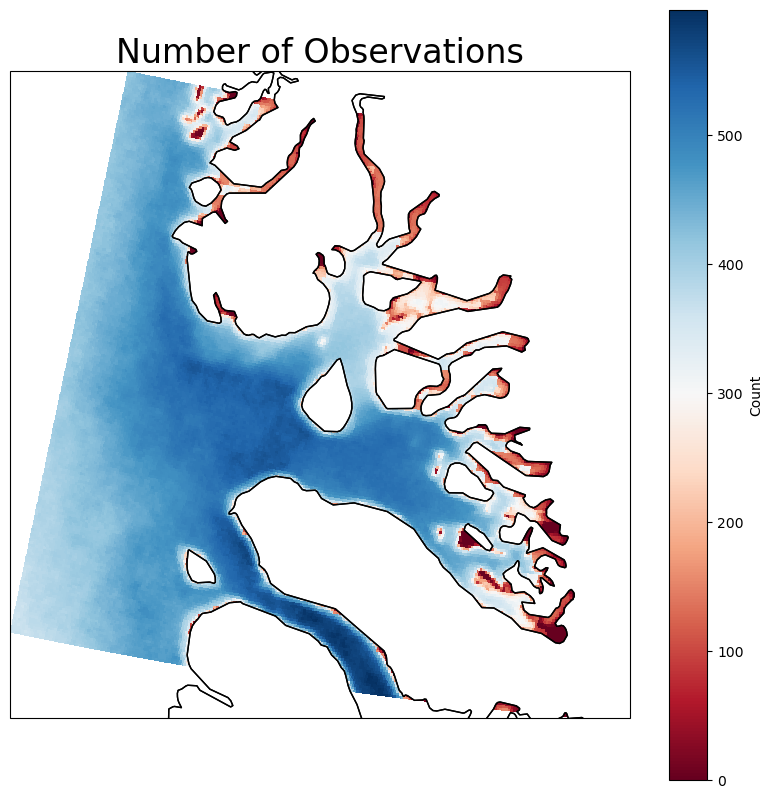

In [16]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
non_nan_count.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', cbar_kwargs={'label': 'Count'})
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')

plt.title('Number of Observations', fontsize=24)

plt.show()
plt.close()

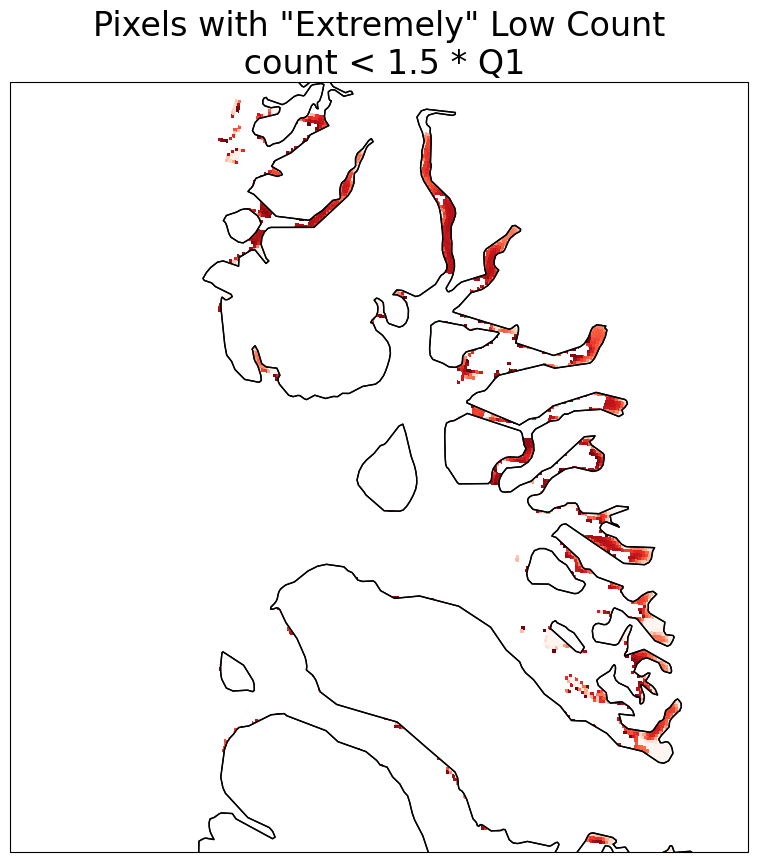

In [27]:
# Create a new array where the values are NaN where the count is not less than the lower bound
low_count_data = non_nan_count.where(non_nan_count < lower_bound)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
low_count_data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', add_colorbar=False)
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
# add title
plt.title('Pixels with "Extremely" Low Count\n count < 1.5 * Q1', fontsize=24)

plt.show()
plt.close()

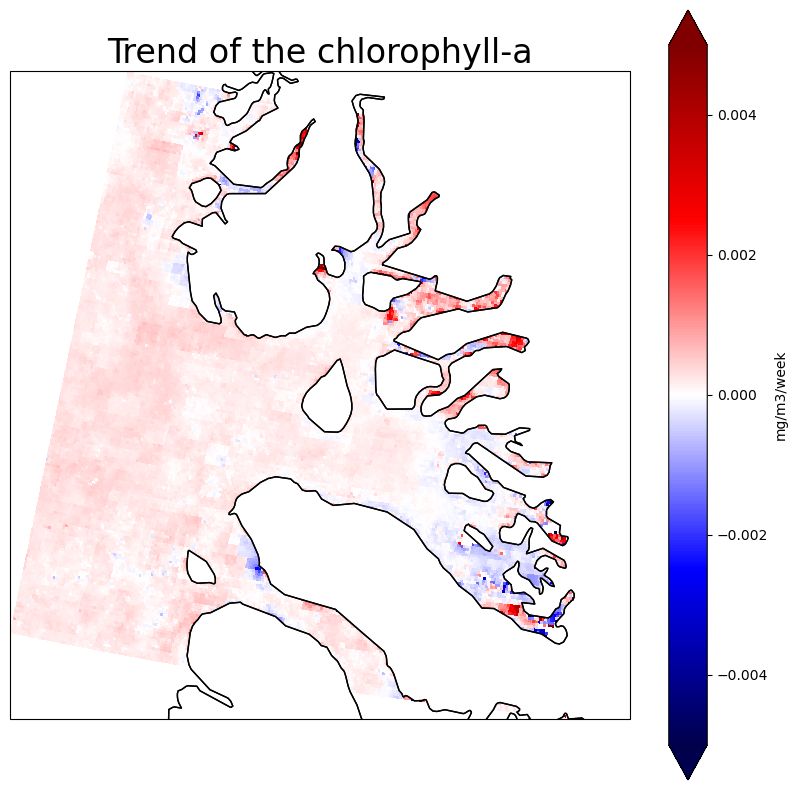

In [35]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
trendline_ds['slope'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='seismic', cbar_kwargs={'label': 'mg/m3/week'}, vmin = -.005, vmax = .005)
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')

plt.title('Trend of the chlorophyll-a', fontsize=24)

plt.show()
plt.close()

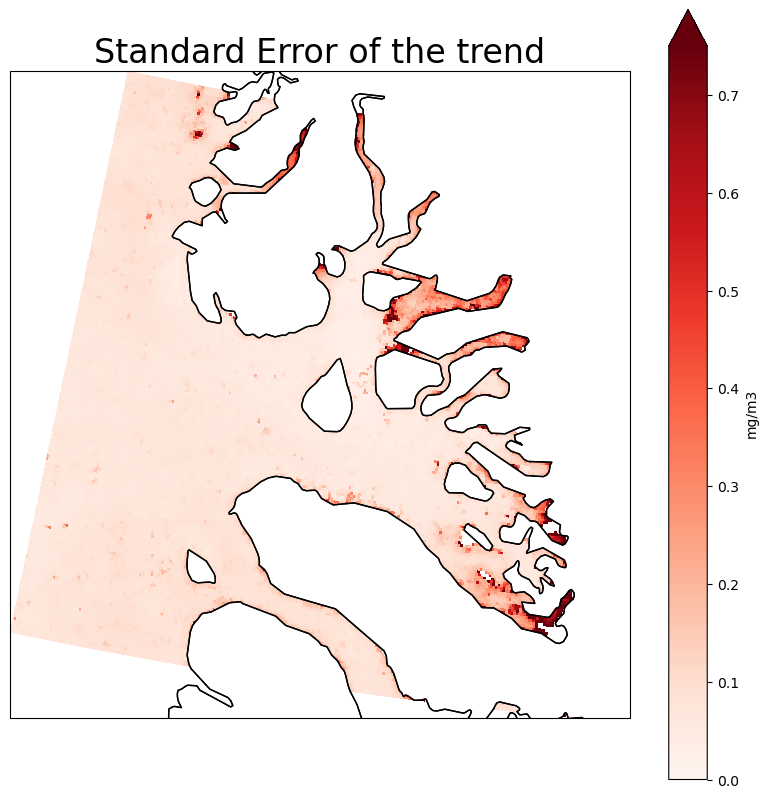

In [36]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
trendline_ds['stderr'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', cbar_kwargs={'label': 'mg/m3'}, vmin = 0, vmax = .75)
ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')

plt.title('Standard Error of the trend', fontsize=24)

plt.show()
plt.close()

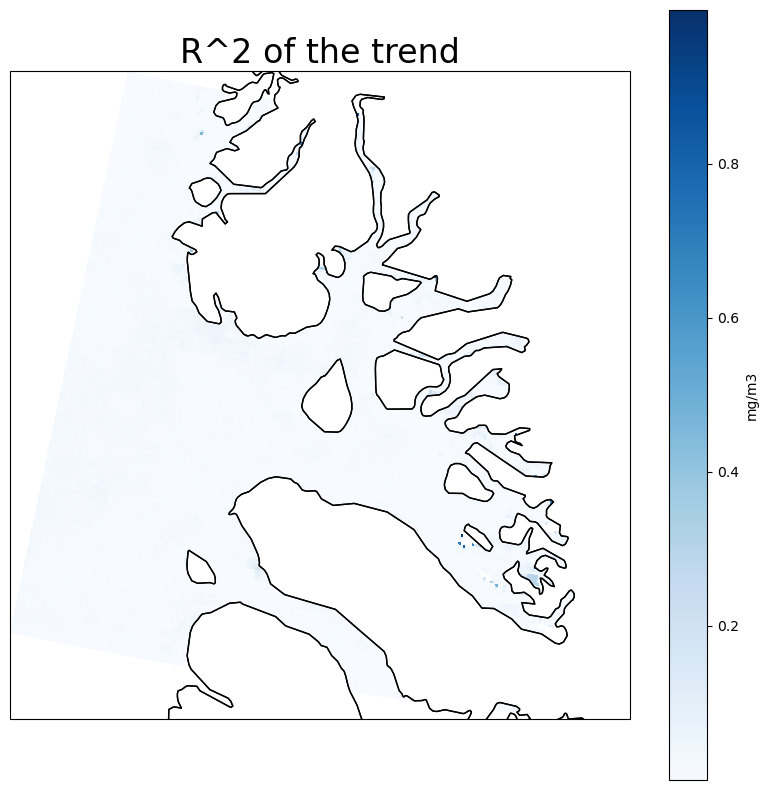

In [37]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
trendline_ds['r_squared'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'mg/m3'}) #, vmin=0, vmax=1)

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')

plt.title('R^2 of the trend', fontsize=24)

plt.show()
plt.close()